In [34]:
from brainsmash.mapgen.base import Base
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp
import json
import numpy as np
import os
from os.path import join as ospj
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


In [71]:
def brainSMASH(distMat,map1,map2,bundle_name,labels,nh=25,pv=25):
    gen = Base(map2,distMat,resample=True,nh=nh,pv=pv)
    surrogate_maps = gen(n=1000)
    
    #generate all surrogate correlations
    surrogate_brainmap_corrs = pearsonr(map1, surrogate_maps).flatten()
    surrogate_pairwise_corrs = pairwise_r(surrogate_maps, flatten=True)
    np.savetxt(ospj(brainsmash_dir, "surrogate_brainmap_corrs_%s_map.txt"%(bundle_name)),surrogate_brainmap_corrs,delimiter=",")
    
    
    naive_surrogates = np.array([np.random.permutation(map1) for _ in range(5000)])
    naive_brainmap_corrs = pearsonr(map2, naive_surrogates).flatten()
    naive_pairwise_corrs = pairwise_r(naive_surrogates, flatten=True)
    np.savetxt(ospj(brainsmash_dir, "surrogate_naive_corrs_%s_map.txt"%(bundle_name)),naive_brainmap_corrs,delimiter=",")
    
    # The observed correlation
    test_stat = stats.pearsonr(map1, map2)[0]
    
    #Plotting
    sac = '#99C9C7'  # autocorr-preserving color
    rc = '#E69982'  # randomly shuffled color
    bins = np.linspace(-1, 1, 51)  # correlation b

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.2, 0.25, 0.6, 0.6])  # autocorr preserving
    ax2 = ax.twinx()  # randomly shuffled

    # plot the data
    ax.axvline(test_stat, 0, 0.8, color='k', linestyle='dashed', lw=1)
    ax.hist(surrogate_brainmap_corrs, bins=bins, color=sac, alpha=1,
        density=True, clip_on=False, zorder=1)
    ax2.hist(naive_brainmap_corrs, bins=bins, color=rc, alpha=0.7,
        density=True, clip_on=False, zorder=2)

    # make the plot nice...
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.spines['left'].set_color(sac)
    ax.tick_params(axis='y', colors=sac)
    ax2.spines['right'].set_color(rc)
    ax2.tick_params(axis='y', colors=rc)
    ax.set_ylim(0, 2)
    ax2.set_ylim(0, 6)
    ax.set_xlim(-1, 1)
    [s.set_visible(False) for s in [
        ax.spines['top'], ax.spines['right'], ax2.spines['top'], ax2.spines['left']]]
    ax.text(0.97, .96, 'Permutation', ha='right',va='bottom',
        color=rc, transform=ax.transAxes)
    ax.text(0.97, .9, 'brainSMASH', ha='right', va='bottom',
        color=sac, transform=ax.transAxes)
    ax.text(test_stat, 1.65, "%s\nmap"%labels[0], ha='center', va='bottom') # type of age effect
    ax.text(0.5, -0.2, "Pearson correlation\nfor %s map"%labels[1], # tract
        ha='center', va='top', transform=ax.transAxes)
    ax.text(-0.3, 0.5, "Density", rotation=90, ha='left', va='center', transform=ax.transAxes)
    #plt.title(labels[2])
    plt.show()
    
    

    print("r = ", test_stat)
    print("Spatially naive p-value = ", nonparp(test_stat, naive_brainmap_corrs))
    print("SA-corrected p-value = ", nonparp(test_stat, surrogate_brainmap_corrs))
    print("Critical surrogate brain map corr value = ", np.quantile(surrogate_brainmap_corrs,.95))

In [35]:
config_file="/cbica/projects/luo_wm_dev/code/tract_profiles/config/config_HCPD.json"
 
# Read config from the specified file
with open(config_file, "rb") as f:
    config = json.load(f)

dataset = config['dataset']
data_root = config['data_root']
outputs_root = config['outputs_root']
outputs_dir = ospj(outputs_root, "all_subjects")
brainsmash_dir = ospj(outputs_root, "brainsmash_corrs")

if not os.path.exists(brainsmash_dir):
    os.makedirs(brainsmash_dir)
    print(f"{brainsmash_dir} created")

/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/brainsmash_corrs created


In [26]:
# load files
gam_age_md = pd.read_csv("/cbica/projects/luo_wm_dev/output/HCPD/tract_profiles/GAM/dti_md/GAM_bilateral_signedresults.dti_md.age.csv")
bilat_gm_dist = pd.read_csv(ospj(outputs_dir, "across_subjects_bilateral_distances_to_gm.csv"))

,Unnamed: 0,tract_node_noHemi,s_age.delta.adj.rsq_signed,tractID
300,301,Corticospinal Tract_0,-0.080108,Corticospinal Tract
301,302,Corticospinal Tract_1,-0.494872,Corticospinal Tract
302,303,Corticospinal Tract_10,-0.447288,Corticospinal Tract
303,304,Corticospinal Tract_11,-0.432034,Corticospinal Tract
304,305,Corticospinal Tract_12,-0.417711,Corticospinal Tract
...,...,...,...,...
395,396,Corticospinal Tract_95,-0.082343,Corticospinal Tract
396,397,Corticospinal Tract_96,-0.089078,Corticospinal Tract
397,398,Corticospinal Tract_97,-0.099739,Corticospinal Tract
398,399,Corticospinal Tract_98,-0.108388,Corticospinal Tract


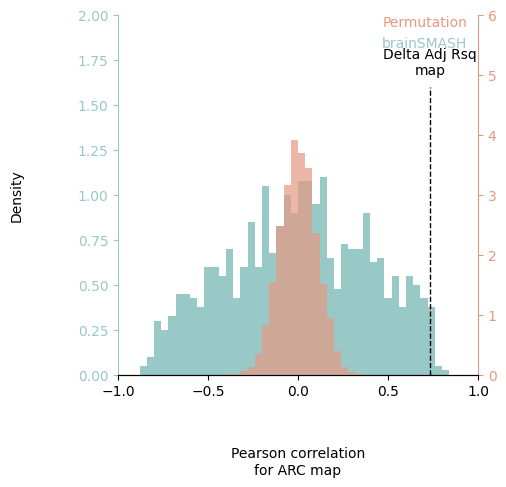

r =  0.734066051611688
Spatially naive p-value =  0.0
SA-corrected p-value =  0.036
Critical surrogate brain map corr value =  0.6557292424859107


In [72]:

# ARC
bundle_name = "ARC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Arcuate Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])

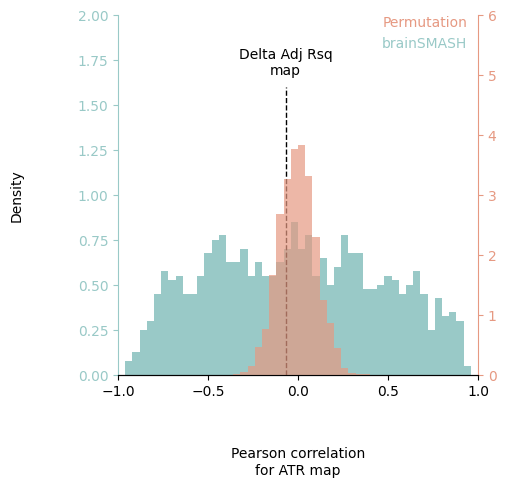

r =  -0.06850610005099586
Spatially naive p-value =  0.5018
SA-corrected p-value =  0.894
Critical surrogate brain map corr value =  0.7790433551504912


In [73]:
# ATR
bundle_name = "ATR"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Anterior Thalamic Radiation"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


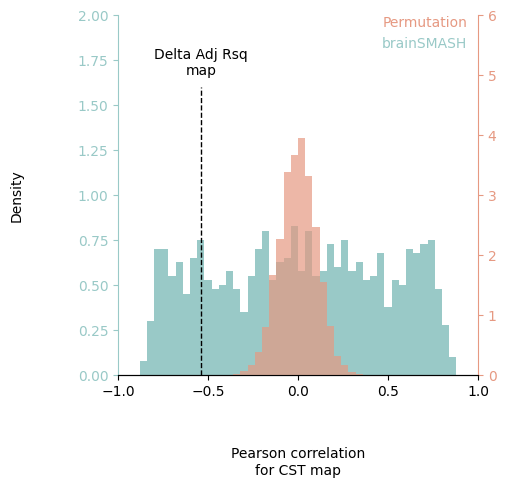

r =  -0.5397707804039421
Spatially naive p-value =  0.0
SA-corrected p-value =  0.359
Critical surrogate brain map corr value =  0.7304061061337094


In [74]:
# CST
bundle_name = "CST"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Corticospinal Tract"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


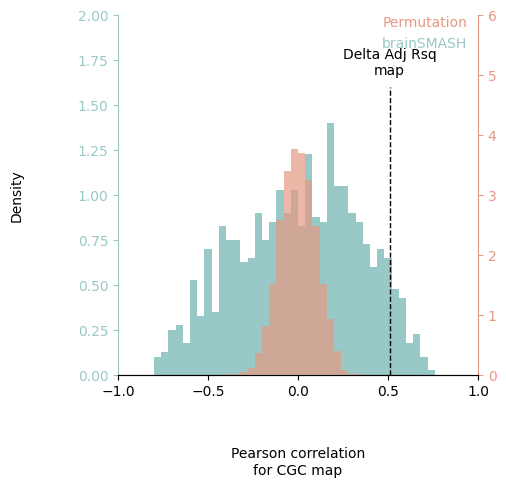

r =  0.5096532684914277
Spatially naive p-value =  0.0
SA-corrected p-value =  0.138
Critical surrogate brain map corr value =  0.5359931101636043


In [75]:
# CGC
bundle_name = "CGC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Cingulum Cingulate"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


In [ ]:
bundles = ["ARCL", "ARCR", "ATRL", "ATRR", "CGCL", "CGCR",  "CSTL", "CSTR", "FA", "FP", "IFOL", "IFOR", "ILFL", "ILFR","pARCL", "pARCR","SLFL", "SLFR","UNCL", "UNCR","VOFL", "VOFR"]


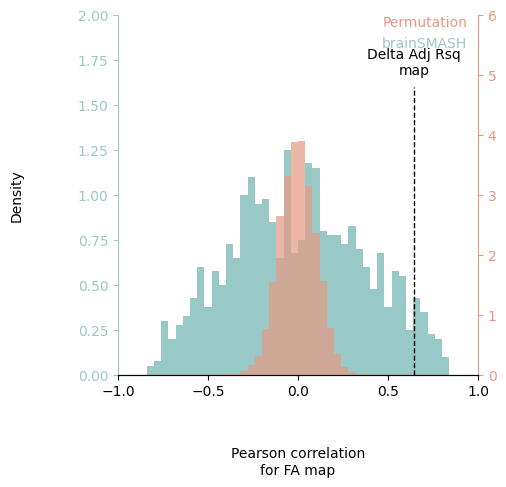

r =  0.6445330955352141
Spatially naive p-value =  0.0
SA-corrected p-value =  0.085
Critical surrogate brain map corr value =  0.6492015957120804


In [76]:
# FA
bundle_name = "FA"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Forceps Minor"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


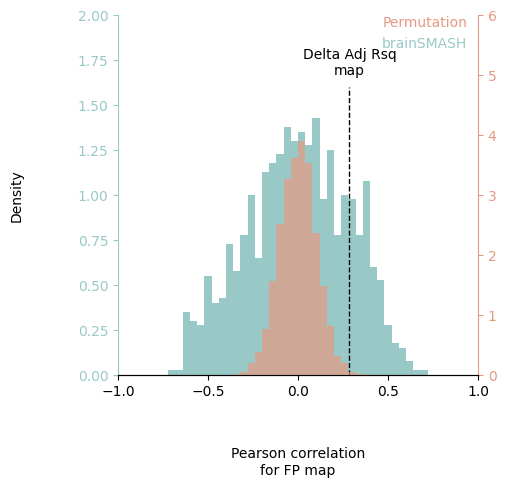

r =  0.28559898958680696
Spatially naive p-value =  0.0044
SA-corrected p-value =  0.354
Critical surrogate brain map corr value =  0.44014314274598354


In [77]:
# FP
bundle_name = "FP"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Forceps Major"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


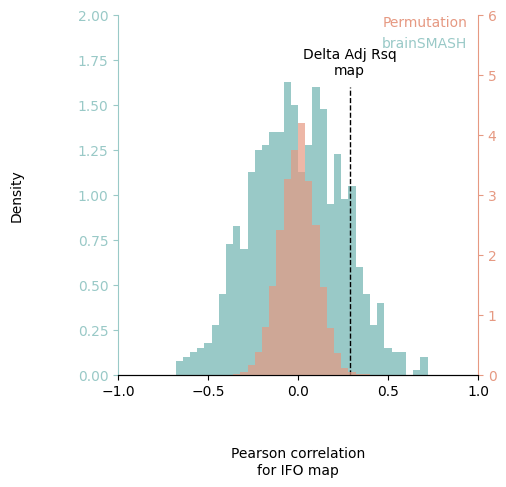

r =  0.2865069299047847
Spatially naive p-value =  0.0036
SA-corrected p-value =  0.266
Critical surrogate brain map corr value =  0.3947214967424927


In [78]:
# IFO
bundle_name = "IFO"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Inferior Fronto-occipital Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


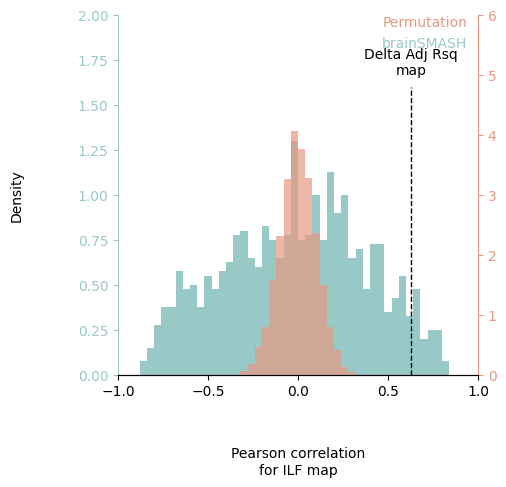

r =  0.6284901434782543
Spatially naive p-value =  0.0
SA-corrected p-value =  0.131
Critical surrogate brain map corr value =  0.639809719536496


In [79]:
# ILF
bundle_name = "ILF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Inferior Longitudinal Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


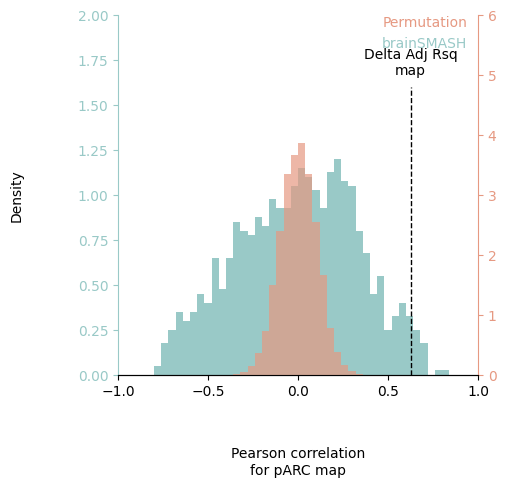

r =  0.6250515991029545
Spatially naive p-value =  0.0
SA-corrected p-value =  0.062
Critical surrogate brain map corr value =  0.5488291587197835


In [80]:
# pARC
bundle_name = "pARC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Posterior Arcuate"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


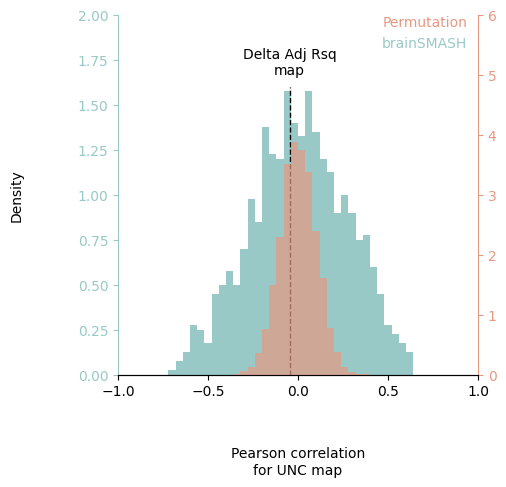

r =  -0.04626066481371471
Spatially naive p-value =  0.6478
SA-corrected p-value =  0.868
Critical surrogate brain map corr value =  0.43951382682648543


In [81]:
# UNC
bundle_name = "UNC"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Uncinate Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


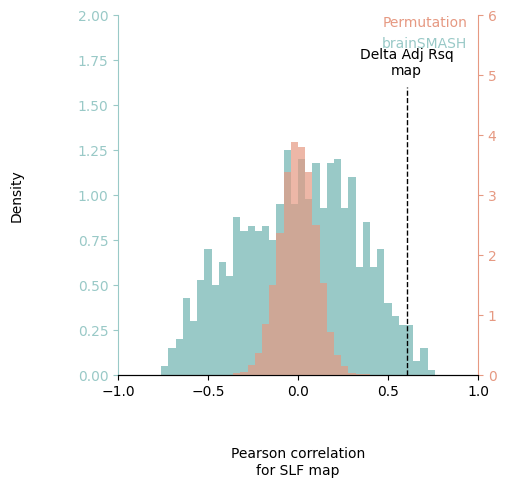

r =  0.6033747969442355
Spatially naive p-value =  0.0
SA-corrected p-value =  0.05
Critical surrogate brain map corr value =  0.5021938148125081


In [82]:
# SLF
bundle_name = "SLF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Superior Longitudinal Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])


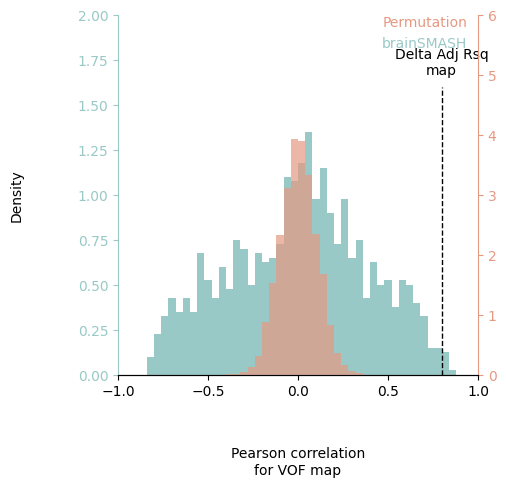

r =  0.7978140403870994
Spatially naive p-value =  0.0
SA-corrected p-value =  0.011
Critical surrogate brain map corr value =  0.6321311031126466


In [83]:
# VOF
bundle_name = "VOF"
distMat = pd.read_csv(ospj(outputs_dir, f"bilat_{bundle_name}_distance_matrix.csv"),header=None)
distMat = distMat.to_numpy().astype(float)

dist_to_gm = bilat_gm_dist[bilat_gm_dist['bundle_name'] == bundle_name].to_numpy()
dist_to_gm_arc = np.delete(dist_to_gm[0], 0)
dist_to_gm_arc = dist_to_gm_arc.astype(float)

age_effect_map = gam_age_md[gam_age_md["tractID"] == "Vertical Occipital Fasciculus"]["s_age.delta.adj.rsq_signed"].to_numpy().astype(float)

brainSMASH(distMat=distMat,map1=dist_to_gm_arc,bundle_name=bundle_name,map2=age_effect_map,labels=["Delta Adj Rsq", bundle_name])
